# Global 
## Data: `assets/Energy Indicators.xls`
- which is a list of indicators of [energy supply and renewable electricity production](assets/Energy%20Indicators.xls) from the [United Nations](http://unstats.un.org/unsd/environment/excel_file_tables/2013/Energy%20Indicators.xls) for the year 2013
- columns: `['Country', 'Energy Supply', 'Energy Supply per Capita', '% Renewable]`

## Data: `assets/world_bank.csv`
-  which is a csv containing countries' GDP from 1960 to 2015 from [World Bank](http://data.worldbank.org/indicator/NY.GDP.MKTP.CD)

## Data: `assets/world_bank.csv` 
- which ranks countries based on their journal contributions in the aforementioned area [Sciamgo Journal and Country Rank data for Energy Engineering and Power Technology](http://www.scimagojr.com/countryrank.php?category=2102)

In [21]:
import pandas as pd
import numpy as np
import regex as re
import collections
import warnings
warnings.filterwarnings('ignore')

# function to display head and tails of a df
def display_head_tails(df, number):
    print("Head:")
    display(df.head(number))
    print("Tail:")
    display(df.tail(number))


## Energy Indicators data set:
- Converting `Energy Supply` to gigajoules. 
- Chaning missing data to `np.NaN` values.
- Removing parenthesis and numeric digits in their name. 
- Renaming the following list of countries:

```"Republic of Korea": "South Korea",
"United States of America": "United States",
"United Kingdom of Great Britain and Northern Ireland": "United Kingdom",
"China, Hong Kong Special Administrative Region": "Hong Kong"```


In [22]:
def Energy_df_setup():

    # Energy DF
    Energy = pd.read_excel('assets/Energy Indicators.xlsx', skiprows=17, skipfooter=38, usecols=[i for i in range(2, 6)], 
                            names=['Country', 'Energy Supply', 'Energy Supply per Capita', '% Renewable'])
    
    # extract parenthesis and numbers
    Energy['Country'] = Energy['Country'].apply(lambda x: re.sub(r'\([^)]*\)|\d', '', x))
    
     # rename countries
    rename_dict = {"Republic of Korea": "South Korea", "United States of America": "United States", "United Kingdom of Great Britain and Northern Ireland": "United Kingdom",
                   "China, Hong Kong Special Administrative Region": "Hong Kong"}
    
    Energy['Country'] = Energy['Country'].apply(lambda x: x.strip())
    Energy['Country'] = Energy['Country'].replace(rename_dict)
    
    # Convert Energy Supply to gigajoules 
    #Energy['Energy Supply'] = Energy['Energy Supply'].apply(lambda x: int(x * 1000000) if type(x) != str else np.nan)
    Energy['Energy Supply'] = Energy['Energy Supply'].apply(lambda x: x * 1000000 if isinstance(x, int) else np.nan)
    #Energy['Energy Supply'] = Energy['Energy Supply'].apply(lambda x: x * 1000000)
    
    return Energy

## GDP data set:
- making first row column labels and casting yrs from float to int
- renaming the following list of countries:
```"Korea, Rep.": "South Korea", 
"Iran, Islamic Rep.": "Iran",
"Hong Kong SAR, China": "Hong Kong"```

In [23]:
def GDP_df_setup():
    # GDP DF
    GDP = pd.read_csv('assets/world_bank.csv', skiprows=3)
    
    # making first row column labels and casting yrs from float to int
    columns = GDP.iloc[0]
    for i in range(4, len(GDP.columns)):
        #columns[i] = pd.to_datetime(columns[i], format='%Y')
        columns[i] = str(int(columns[i]))
    
    GDP.columns = columns 
    GDP = GDP[1:]

    # rename Country column and countries
    GDP.rename(columns={'Country Name':'Country'}, inplace=True)
    GDP['Country'] = GDP['Country'].apply(lambda x: x.strip())
    rename_dict = {"Korea, Rep.": "South Korea",  "Iran, Islamic Rep.": "Iran", "Hong Kong SAR, China": "Hong Kong"}
    GDP['Country'] = GDP['Country'].replace(rename_dict)
    
    return GDP

## joining the three data sets
Joining the three datasets: GDP, Energy, and ScimEn into a new dataset (using the intersection of country names). Using only the last 10 years (2006-2015) of GDP data and only the top 15 countries by Scimagojr 'Rank' (Rank 1 through 15). 

The index of this DataFrame is the name of the country, and the columns are ['Rank', 'Documents', 'Citable documents', 'Citations', 'Self-citations',
       'Citations per document', 'H index', 'Energy Supply',
       'Energy Supply per Capita', '% Renewable', '2006', '2007', '2008',
       '2009', '2010', '2011', '2012', '2013', '2014', '2015'].

In [27]:
def joining_dataSets():
    Energy = Energy_df_setup()
    GDP = GDP_df_setup()
    ScimEn = pd.read_excel('assets/scimagojr-3.xlsx')

    
    # Final DF
    # Final edits to GDP DF: using only last 10 columns but keeping country one
    GDP_country_column = GDP['Country'].values.tolist()
    GDP = GDP.iloc[: , -10:]
    GDP.insert(0, "Country", GDP_country_column, True) 
    
    # Final edits to ScimEn: only use top 15 countries
    ScimEn = ScimEn.iloc[:15]
    
    # Final merge
    final_df = pd.merge(Energy, GDP, how='inner', on = 'Country')
    final_df = pd.merge(final_df, ScimEn, how='inner', on = 'Country')
    final_df.set_index("Country", inplace = True)
    # re-order columns to fit given order
    final_df = final_df.rename(columns=lambda x: x.strip())
    final_df = final_df[['Rank', 'Documents', 'Citable documents', 'Citations', 'Self-citations', 'Citations per document', 'H index', 'Energy Supply', 'Energy Supply per Capita', '% Renewable', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015']]
    # sort by 'Rank'
    final_df.sort_values(by=['Rank'], inplace=True)
    #display_head_tails(final_df, 50)
    
    return final_df


In [44]:
main_df = joining_dataSets()
display(main_df)

,Rank,Documents,Citable documents,Citations,Self-citations,Citations per document,H index,Energy Supply,Energy Supply per Capita,% Renewable,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
Country,,,,,,,,,,,,,,,,,,,,
China,1,127050,126767,597237,411683,4.70,138,1.271910e+11,93,19.754910,3.992331e+12,4.559041e+12,4.997775e+12,5.459247e+12,6.039659e+12,6.612490e+12,7.124978e+12,7.672448e+12,8.230121e+12,8.797999e+12
United States,2,96661,94747,792274,265436,8.20,230,9.083800e+10,286,11.570980,1.479230e+13,1.505540e+13,1.501149e+13,1.459484e+13,1.496437e+13,1.520402e+13,1.554216e+13,1.577367e+13,1.615662e+13,1.654857e+13
Japan,3,30504,30287,223024,61554,7.31,134,1.898400e+10,149,10.232820,5.496542e+12,5.617036e+12,5.558527e+12,5.251308e+12,5.498718e+12,5.473738e+12,5.569102e+12,5.644659e+12,5.642884e+12,5.669563e+12
United Kingdom,4,20944,20357,206091,37874,9.84,139,7.920000e+09,124,10.600470,2.419631e+12,2.482203e+12,2.470614e+12,2.367048e+12,2.403504e+12,2.450911e+12,2.479809e+12,2.533370e+12,2.605643e+12,2.666333e+12
Russian Federation,5,18534,18301,34266,12422,1.85,57,3.070900e+10,214,17.288680,1.385793e+12,1.504071e+12,1.583004e+12,1.459199e+12,1.524917e+12,1.589943e+12,1.645876e+12,1.666934e+12,1.678709e+12,1.616149e+12
Canada,6,17899,17620,215003,40930,12.01,149,1.043100e+10,296,61.945430,1.564469e+12,1.596740e+12,1.612713e+12,1.565145e+12,1.613406e+12,1.664087e+12,1.693133e+12,1.730688e+12,1.773486e+12,1.792609e+12
Germany,7,17027,16831,140566,27426,8.26,126,1.326100e+10,165,17.901530,3.332891e+12,3.441561e+12,3.478809e+12,3.283340e+12,3.417298e+12,3.542371e+12,3.556724e+12,3.567317e+12,3.624386e+12,3.685556e+12
India,8,15005,14841,128763,37209,8.58,115,3.319500e+10,26,14.969080,1.265894e+12,1.374865e+12,1.428361e+12,1.549483e+12,1.708459e+12,1.821872e+12,1.924235e+12,2.051982e+12,2.200617e+12,2.367206e+12
France,9,13153,12973,130632,28601,9.93,114,1.059700e+10,166,17.020280,2.607840e+12,2.669424e+12,2.674637e+12,2.595967e+12,2.646995e+12,2.702032e+12,2.706968e+12,2.722567e+12,2.729632e+12,2.761185e+12


### Entries lost by joining data sets
The previous cell joined three datasets then reduced this to just the top 15 entries. How many entries were lost?


In [33]:
def entries_lost():
    Energy = Energy_df_setup()
    GDP = GDP_df_setup()
    ScimEn = pd.read_excel('assets/scimagojr-3.xlsx')
    
    #joining
    inner = pd.merge(pd.merge(Energy,GDP,on='Country',how='inner'),ScimEn,on='Country',how='inner')
    outer = pd.merge(pd.merge(Energy,GDP,on='Country',how='outer'),ScimEn,on='Country',how='outer')
    
    return len(outer.index) - len(inner.index)
    



In [34]:
print('Entries lost: ', entries_lost())

Entries lost:  158


### Top 15 countries for average GDP over the last 10 years

In [50]:
def top_15_countries():
    # top 15 countries for average GDP over the last 10 years
    last_10_years = main_df.columns.tolist()[-10:]
    avgGDP = main_df[last_10_years].apply(np.nanmean, axis = 1).sort_values(ascending = False)

    return avgGDP

In [51]:
top_15_avgGDP = top_15_countries()
print('Top 15 countries for average GDP over the last 10 years', top_15_avgGDP)

Top 15 countries for average GDP over the last 10 years Country
United States         1.536434e+13
China                 6.348609e+12
Japan                 5.542208e+12
Germany               3.493025e+12
France                2.681725e+12
United Kingdom        2.487907e+12
Brazil                2.189794e+12
Italy                 2.120175e+12
India                 1.769297e+12
Canada                1.660647e+12
Russian Federation    1.565459e+12
Spain                 1.418078e+12
Australia             1.164043e+12
South Korea           1.106715e+12
Iran                  4.441558e+11
dtype: float64


### By how much had the GDP changed over the 10 year span for the country with the 6th largest average GDP?

In [52]:
def gdp_change_sixth_country():
    sixth_largest_avgGDP = main_df.loc[top_15_avgGDP.index[5]]
    change_in_gdp = abs(sixth_largest_avgGDP['2006'] - sixth_largest_avgGDP['2015'])
    
    return change_in_gdp


In [53]:

print('The 6th largest average GDP has changed in ', gdp_change_sixth_country())

The 6th largest average GDP has changed in  246702696075.3999


### Mean energy supply per capita

In [57]:
mean_ES_pc = main_df['Energy Supply per Capita'].mean()
print('The mean energy supply per capita is: ', mean_ES_pc)

The mean energy supply per capita is:  157.6


### Country with the maximum % Renewable Energy

In [62]:
def max_renewable():
    id_max = main_df[['% Renewable']].idxmax()
    max_percentage_row = main_df.loc[id_max[0]]
    return(id_max[0], max_percentage_row['% Renewable'])


In [65]:
max_country = max_renewable()
print('The country with the maximum renewable energy is {} with {:.3f}%'.format(max_country[0], max_country[1]))

The country with the maximum renewable energy is Brazil with 69.648%


### Ratio of Self-Citations to Total Citations column

In [69]:
def citations_ratio():
    main_df['Self-Citations to Total Citations ratio'] = main_df["Self-citations"] / main_df["Citations"]
    id_max = main_df[['Self-Citations to Total Citations ratio']].idxmax()
    max_ratio_row = main_df.loc[id_max[0]]
    return(id_max[0], max_ratio_row['Self-Citations to Total Citations ratio'])


In [70]:
answer = citations_ratio()
country = answer[0]
ratio = answer[1]
print('The country with the maximum ratio of Self-citations to total citations is {} with {}'.format(country,ratio))

The country with the maximum ratio of Self-citations to total citations is China with 0.6893126179389422


### Population estimate
Column that estimates the population using Energy Supply and Energy Supply per capita. 


In [71]:
def population_estimate():
    main_df['Pop. estimate'] = main_df['Energy Supply']/main_df['Energy Supply per Capita']
    third_most_pop = main_df.sort_values(by='Pop. estimate',ascending=False).index[2]
    return third_most_pop

In [72]:
country = population_estimate()
print("The country with the third biggest estimated population is ", country)

The country with the third biggest estimated population is  United States


### Citable documents per person
- Creates a column that estimates the number of citable documents per person. <br> 
- Returns the correlation between the number of citable documents per capita and the energy supply per capita<br>
- Plots the relation btw those to variables

In [76]:
def add_PopEst_column(Top15):
    Top15['PopEst'] = Top15['Energy Supply'] / Top15['Energy Supply per Capita']

def citable_documents_per_person():    
    Top15 = main_df
    
    #estimates the number of citable documents per person
    Top15['PopEst'] = Top15['Energy Supply'] / Top15['Energy Supply per Capita']
    
    #citable documents per capita
    Top15['Citable docs per Capita'] = Top15['Citable documents'] / Top15['PopEst']
    
    #cast both columns to float because there are of type object apparently corr does not work
    Top15['Citable docs per Capita'] = Top15['Citable docs per Capita'].astype(float)
    Top15['Energy Supply per Capita'] = Top15['Energy Supply per Capita'].astype(float)
    
    #calc corr btw columns
    corr = Top15['Citable docs per Capita'].corr(Top15['Energy Supply per Capita'])
    
    #plot
    Top15.plot(x='Citable docs per Capita', y='Energy Supply per Capita', kind='scatter', xlim=[0, 0.0006])
    
    return corr



The correlation between the number of citable documents per capita and the energy supply per capita is: 0.7940010435442946


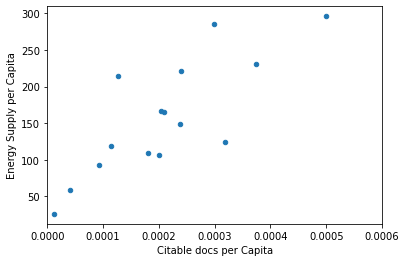

In [77]:
print("The correlation between the number of citable documents per capita and the energy supply per capita is:", citable_documents_per_person())

### Is % Renewable above or below the meadian, column:
- 1  if the country's % Renewable value is at or above the median for all countries in the top 15
- 0 if the country's % Renewable value is below the median.


In [80]:
def renewable_above_median(x, median):
    if x >= median:
        return 1
    else:
        return 0
    
def renewable_median():
    median = main_df['% Renewable'].median(axis = 0)
    main_df['HighRenew'] = main_df['% Renewable'].apply(lambda x: renewable_above_median(x, median))
    HighRenew = main_df['HighRenew'].squeeze()
    display(HighRenew)
    
    return HighRenew

In [81]:
print(renewable_median())

Country
China                 1
United States         0
Japan                 0
United Kingdom        0
Russian Federation    1
Canada                1
Germany               1
India                 0
France                1
South Korea           0
Italy                 1
Spain                 1
Iran                  0
Australia             0
Brazil                1
Name: HighRenew, dtype: int64

Country
China                 1
United States         0
Japan                 0
United Kingdom        0
Russian Federation    1
Canada                1
Germany               1
India                 0
France                1
South Korea           0
Italy                 1
Spain                 1
Iran                  0
Australia             0
Brazil                1
Name: HighRenew, dtype: int64


### Grouping countries by continent
- Creates a DataFrame that displays the sample size (the number of countries in each continent bin), and the sum, mean, and std deviation for the estimated population of each country.
Use the following dictionary to group the Countries by Continent, then create a DataFrame 


In [86]:
def add_PopEst_column(Top15):
    Top15['PopEst'] = Top15['Energy Supply'] / Top15['Energy Supply per Capita']

def set_continent(item, cont_dict):
    return cont_dict[item]

def add_cont_column(main_df):
    ContinentDict  = {'China':'Asia', 
                  'United States':'North America', 
                  'Japan':'Asia', 
                  'United Kingdom':'Europe', 
                  'Russian Federation':'Europe', 
                  'Canada':'North America', 
                  'Germany':'Europe', 
                  'India':'Asia',
                  'France':'Europe', 
                  'South Korea':'Asia', 
                  'Italy':'Europe', 
                  'Spain':'Europe', 
                  'Iran':'Asia',
                  'Australia':'Australia', 
                  'Brazil':'South America'}
    
    main_df['Continent'] = main_df['Country'].apply(lambda x: set_continent(x, ContinentDict))

def grouping_countries_by_continent():
    main_df = joining_dataSets()
     
    # add Continent and PopEst columns 
    main_df = main_df.reset_index()
    add_cont_column(main_df)
    add_PopEst_column(main_df)
    main_df = main_df.set_index('Country')
    
    # start new dataframe
    df = pd.DataFrame()
    
    for group, frame in main_df.groupby('Continent'):
        size = len(frame)
        sum = np.sum(frame['PopEst'])
        mean = np.mean(frame['PopEst'])
        std = np.std(frame['PopEst'], ddof = 1)
        df = df.append({'Continent': group, 'size':size, 'sum':sum, 'mean':mean, 'std':std}, ignore_index=True)
    
    df = df.set_index('Continent')

    return df
    
    

In [87]:
print(grouping_countries_by_continent())

                       mean  size           std           sum
Continent                                                    
Asia           5.797333e+08   5.0  6.790979e+08  2.898666e+09
Australia      2.331602e+07   1.0           NaN  2.331602e+07
Europe         7.632161e+07   6.0  3.464767e+07  4.579297e+08
North America  1.764276e+08   2.0  1.996696e+08  3.528552e+08
South America  2.059153e+08   1.0           NaN  2.059153e+08


### Convert the Population Estimate series to a string with thousands separator (using commas)Convert the Population Estimate series to a string with thousands separator (using commas)
- Uses all significant digits (do not round the results).

e.g. 12345678.90 -> 12,345,678.90


In [89]:
def population_to_string():
    main_df = joining_dataSets()
    add_PopEst_column(main_df)
    result = main_df['PopEst'].apply(lambda x: '{0:,}'.format(x)).astype(str)
    display(result)
    return result
    

In [90]:
print(population_to_string())

Country
China                 1,367,645,161.2903225
United States          317,615,384.61538464
Japan                  127,409,395.97315437
United Kingdom         63,870,967.741935484
Russian Federation            143,500,000.0
Canada                  35,239,864.86486486
Germany                 80,369,696.96969697
India                 1,276,730,769.2307692
France                  63,837,349.39759036
South Korea            49,805,429.864253394
Italy                  59,908,256.880733944
Spain                    46,443,396.2264151
Iran                    77,075,630.25210084
Australia              23,316,017.316017315
Brazil                 205,915,254.23728815
Name: PopEst, dtype: object

Country
China                 1,367,645,161.2903225
United States          317,615,384.61538464
Japan                  127,409,395.97315437
United Kingdom         63,870,967.741935484
Russian Federation            143,500,000.0
Canada                  35,239,864.86486486
Germany                 80,369,696.96969697
India                 1,276,730,769.2307692
France                  63,837,349.39759036
South Korea            49,805,429.864253394
Italy                  59,908,256.880733944
Spain                    46,443,396.2264151
Iran                    77,075,630.25210084
Australia              23,316,017.316017315
Brazil                 205,915,254.23728815
Name: PopEst, dtype: object
